# Seasonal Winds
- Roar Collab

In [9]:
import xarray as xr
import numpy as np
import pandas as pd
import glob as glob
import matplotlib.pyplot as plt
import dask

In [2]:
file_in_gridmet = "/storage/group/pches/default/users/dcl5300/gridMET/vs/*"
file_paths_vs = sorted(glob.glob(file_in_gridmet))
file_in_hist_MACA = "/storage/group/pches/default/public/MACA-CMIP5/windspeed_files/historical/macav2metdata_ws_"
file_in_rcp45_MACA = "/storage/group/pches/default/public/MACA-CMIP5/windspeed_files/rcp45/macav2metdata_ws_"
maca_v2_paths = sorted(glob.glob(f'{file_in_hist_MACA}*'))
start_year, end_year = 1979, 2025
lon_max_sc = -116.5
lon_min_sc = -118.5
lat_min_sc = 34
lat_max_sc = 36

## gridmet vs

In [3]:
ws_arr = []
for file_paths_i in file_paths_vs:
    ds_i = xr.open_dataset(file_paths_i)
    ds_i = ds_i.where((ds_i.lon >= lon_min_sc) & (ds_i.lon <= lon_max_sc) & 
                                    (ds_i.lat >= lat_min_sc) & (ds_i.lat <= lat_max_sc), drop=True)
    ds_i = ds_i.sel(day=~((ds_i.day.dt.month == 2) & (ds_i.day.dt.day == 29)))
    spatial_aggregate = ds_i.mean(dim=['lon'])
    spatial_aggregate = spatial_aggregate.mean(dim=['lat'])
    ws_arr.append(spatial_aggregate["wind_speed"].values)
    #plt.plot(spatial_aggregate["wind_speed"].values, alpha=.2)
    
los_angeles_wind_climatology = np.array(ws_arr).mean(axis=0)
ninetyseven_5_percentile = np.percentile(ws_arr, 97.5, axis=0)
two_5_percentile = np.percentile(ws_arr, 2.5, axis=0)

## maca vs

In [4]:
# MACA runs for ws
models = ["BNU-ESM", "CNRM-CM5", "CSIRO-Mk3-6-0", "CanESM2", "GFDL-ESM2G", "GFDL-ESM2M", "HadGEM2-CC365", "HadGEM2-ES365", "IPSL-CM5A-LR",
         "IPSL-CM5A-MR", "IPSL-CM5B-LR", "MIROC-ESM-CHEM", "MIROC-ESM", "MIROC5", "bcc-csm1-1-m", "MRI-CGCM3", "bcc-csm1-1", "inmcm4"]

In [136]:
def model_climatology(model_i):
    '''
    given some model name, returns the climatology of the windspeed for MACAv2 CMIP5 
    inputs
    - model_i
    outputs
    - climatology
    '''
    mavav2_hist_paths = f'{file_in_hist_MACA}{model_i}*'
    mavav2_rcp45_paths = f'{file_in_rcp45_MACA}{model_i}*'
    sorted_hist_paths = sorted(glob.glob(mavav2_hist_paths))
    sorted_rcp45_paths = sorted(glob.glob(mavav2_rcp45_paths))
    all_paths = sorted_hist_paths + (sorted_rcp45_paths)
    correct_paths = []
    for path_i in all_paths:
        start_year_i = int(path_i.split("_")[-4])
        end_year_i = int(path_i.split("_")[-3])
        if ((start_year_i >= start_year) and (end_year_i <= end_year)) or (end_year_i == start_year) or (start_year_i == end_year):
            correct_paths.append(path_i)
    ds_model_i_ws = xr.open_mfdataset(correct_paths)
    ds_model_i_ws["lon"] = np.where(ds_model_i_ws["lon"] > 180, ds_model_i_ws["lon"] - 360, ds_model_i_ws["lon"])
    ds_model_i_ws = ds_model_i_ws.where((ds_model_i_ws.lon >= lon_min_sc) & (ds_model_i_ws.lon <= lon_max_sc) & 
                                    (ds_model_i_ws.lat >= lat_min_sc) & (ds_model_i_ws.lat <= lat_max_sc), drop=True)
    ds_model_i_ws = ds_model_i_ws.sel(time=~((ds_model_i_ws.time.dt.month == 2) & (ds_model_i_ws.time.dt.day == 29)))
    spatial_aggregate_maca = ds_model_i_ws.mean(dim=['lon'])
    spatial_aggregate_maca = spatial_aggregate_maca.mean(dim=['lat'])
    spatial_aggregate_maca_timeslice = spatial_aggregate_maca.sel(time=slice('1979-01-01', '2022-12-31')).compute()
    #values_ws_lazy = spatial_aggregate_maca_timeslice.groupby(spatial_aggregate_maca_timeslice.time.dt.dayofyear).mean().wind_speed
    grouped = spatial_aggregate_maca_timeslice.wind_speed.groupby(spatial_aggregate_maca_timeslice.time.dt.dayofyear)
    # Daily mean
    daily_mean = grouped.mean()
    daily_p025 = grouped.reduce(np.percentile, q=2.5)
    daily_p975 = grouped.reduce(np.percentile, q=97.5)
    daily_mean = daily_mean.dropna('dayofyear', how='all')
    daily_p025 = daily_p025.dropna('dayofyear', how='all')
    daily_p975 = daily_p975.dropna('dayofyear', how='all')
    '''
    p25_ws = spatial_aggregate_maca_timeslice.wind_speed.groupby(spatial_aggregate_maca_timeslice.time.dt.dayofyear).reduce(np.percentile, q=2.5)
    p25_ws = spatial_aggregate_maca_timeslice.wind_speed.groupby(spatial_aggregate_maca_timeslice.time.dt.dayofyear).reduce(np.percentile, q=97.5)'''
    return daily_mean, daily_p025, daily_p975

## dask for memory fixes

In [116]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    account="open",
    cores=1,
    memory="100GiB",
    walltime="02:00:00",
    processes=1
)

cluster.scale(jobs=8)

from dask.distributed import Client

client = Client(cluster)

/storage/work/cta5244/.conda/envs/fwi_env/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37097 instead
  warnings.warn(
Task exception was never retrieved
future: <Task finished name='Task-555403' coro=<Client._gather.<locals>.wait() done, defined at /storage/work/cta5244/.conda/envs/fwi_env/lib/python3.10/site-packages/distributed/client.py:2377> exception=AllExit()>
Traceback (most recent call last):
  File "/storage/work/cta5244/.conda/envs/fwi_env/lib/python3.10/site-packages/distributed/client.py", line 2386, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-555404' coro=<Client._gather.<locals>.wait() done, defined at /storage/work/cta5244/.conda/envs/fwi_env/lib/python3.10/site-packages/distributed/client.py:2377> exception=AllExit()>
Traceback (most recent call last):
  File "/stora

In [117]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://146.186.150.11:37097/status,
Dashboard: http://146.186.150.11:37097/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://146.186.150.11:40059,Workers: 0
Dashboard: http://146.186.150.11:37097/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [137]:
delayed_tasks = []
for model_i in models:    
    delayed_tasks.append(dask.delayed(model_climatology)(model_i))

In [138]:
results = dask.compute(*delayed_tasks)

In [145]:
means_arr = []
p025s_arr = []
p975s_arr = []

for mean_i, p025_i, p975_i in results:
    daily_mean = mean_i.sel(dayofyear=mean_i.dayofyear != 366)
    daily_p025 = p025_i.sel(dayofyear=p025_i.dayofyear != 366)
    daily_p975 = p975_i.sel(dayofyear=p975_i.dayofyear != 366)
    means_arr.append(daily_mean.values)
    p025s_arr.append(daily_p025.values)
    p975s_arr.append(daily_p975.values)

means_arr = np.stack(means_arr)
p025s_arr = np.stack(p025s_arr)
p975s_arr = np.stack(p975s_arr)

ensemble_mean   = means_arr.mean(axis=0)
ensemble_p025   = p025s_arr.mean(axis=0)
ensemble_p975   = p975s_arr.mean(axis=0)

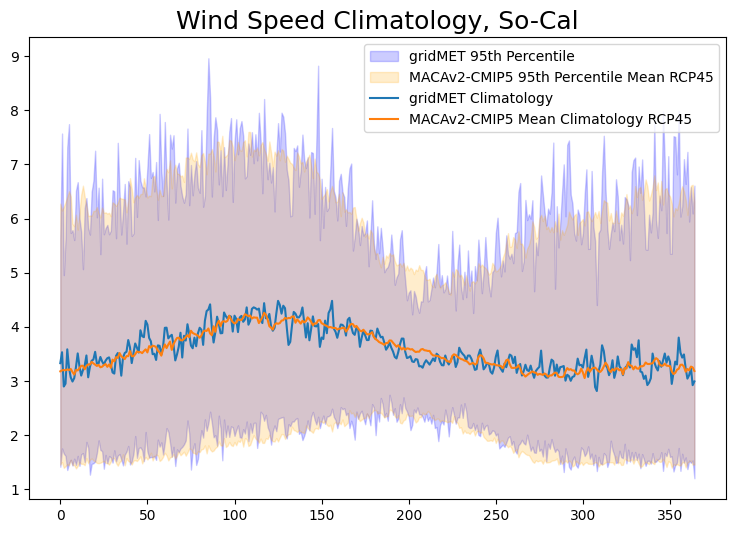

In [158]:
plt.figure(figsize=(9,6))
plt.title('Wind Speed Climatology, So-Cal', fontsize=18)
plt.fill_between(np.arange(0,365), ninetyseven_5_percentile, two_5_percentile, label="gridMET 95th Percentile", color='b', alpha=.2)
plt.fill_between(np.arange(0,365), ensemble_p975, ensemble_p025, label="MACAv2-CMIP5 95th Percentile Mean RCP45", color='orange', alpha=.2)

plt.plot(los_angeles_wind_climatology, label='gridMET Climatology')
plt.plot(ensemble_mean, label='MACAv2-CMIP5 Mean Climatology RCP45')
plt.legend()
plt.savefig('revision_figures/2_wind_speed_climatology_maca_gridmet_socal')

## Nor-Cal

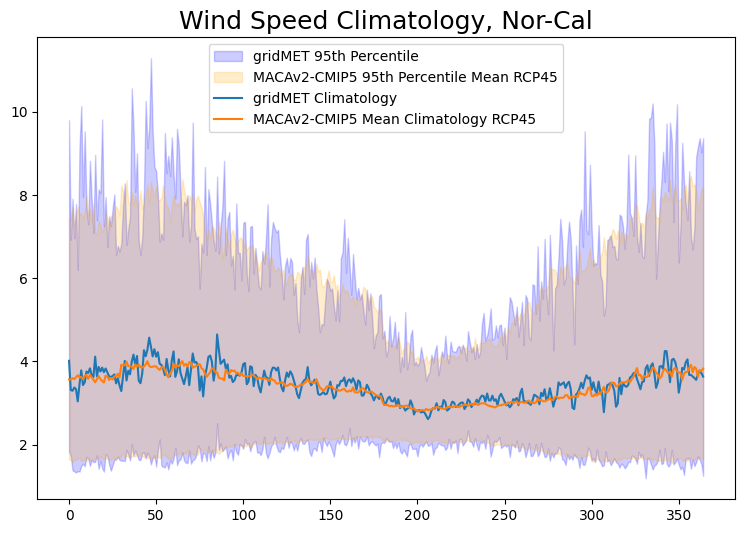

In [161]:
file_in_gridmet = "/storage/group/pches/default/users/dcl5300/gridMET/vs/*"
file_paths_vs = sorted(glob.glob(file_in_gridmet))
file_in_hist_MACA = "/storage/group/pches/default/public/MACA-CMIP5/windspeed_files/historical/macav2metdata_ws_"
file_in_rcp45_MACA = "/storage/group/pches/default/public/MACA-CMIP5/windspeed_files/rcp45/macav2metdata_ws_"
maca_v2_paths = sorted(glob.glob(f'{file_in_hist_MACA}*'))
start_year, end_year = 1979, 2025
lon_max_sc = -121
lon_min_sc = -123
lat_min_sc = 38.5
lat_max_sc = 40.5

ws_arr = []
for file_paths_i in file_paths_vs:
    ds_i = xr.open_dataset(file_paths_i)
    ds_i = ds_i.where((ds_i.lon >= lon_min_sc) & (ds_i.lon <= lon_max_sc) & 
                                    (ds_i.lat >= lat_min_sc) & (ds_i.lat <= lat_max_sc), drop=True)
    ds_i = ds_i.sel(day=~((ds_i.day.dt.month == 2) & (ds_i.day.dt.day == 29)))
    spatial_aggregate = ds_i.mean(dim=['lon'])
    spatial_aggregate = spatial_aggregate.mean(dim=['lat'])
    ws_arr.append(spatial_aggregate["wind_speed"].values)
    #plt.plot(spatial_aggregate["wind_speed"].values, alpha=.2)
    
los_angeles_wind_climatology = np.array(ws_arr).mean(axis=0)
ninetyseven_5_percentile = np.percentile(ws_arr, 97.5, axis=0)
two_5_percentile = np.percentile(ws_arr, 2.5, axis=0)
delayed_tasks = []
for model_i in models:    
    delayed_tasks.append(dask.delayed(model_climatology)(model_i))
results = dask.compute(*delayed_tasks)
means_arr = []
p025s_arr = []
p975s_arr = []

for mean_i, p025_i, p975_i in results:
    daily_mean = mean_i.sel(dayofyear=mean_i.dayofyear != 366)
    daily_p025 = p025_i.sel(dayofyear=p025_i.dayofyear != 366)
    daily_p975 = p975_i.sel(dayofyear=p975_i.dayofyear != 366)
    means_arr.append(daily_mean.values)
    p025s_arr.append(daily_p025.values)
    p975s_arr.append(daily_p975.values)

means_arr = np.stack(means_arr)
p025s_arr = np.stack(p025s_arr)
p975s_arr = np.stack(p975s_arr)

ensemble_mean   = means_arr.mean(axis=0)
ensemble_p025   = p025s_arr.mean(axis=0)
ensemble_p975   = p975s_arr.mean(axis=0)

plt.figure(figsize=(9,6))
plt.title('Wind Speed Climatology, Nor-Cal', fontsize=18)
plt.fill_between(np.arange(0,365), ninetyseven_5_percentile, two_5_percentile, label="gridMET 95th Percentile", color='b', alpha=.2)
plt.fill_between(np.arange(0,365), ensemble_p975, ensemble_p025, label="MACAv2-CMIP5 95th Percentile Mean RCP45", color='orange', alpha=.2)

plt.plot(los_angeles_wind_climatology, label='gridMET Climatology')
plt.plot(ensemble_mean, label='MACAv2-CMIP5 Mean Climatology RCP45')
plt.legend()
plt.savefig('revision_figures/2_wind_speed_climatology_maca_gridmet_norcal')